In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.options import Options  


In [2]:
chrome_options = Options()  
chrome_options.add_argument("--headless")  
chrome_options.add_argument("--no-sandbox")

driver = webdriver.Chrome('chromedriver', options=chrome_options)

In [3]:
# url = 'https://bnonews.com/index.php/2020/02/the-latest-coronavirus-cases/'
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR30F8lYP3jG7YOq8es0PBpJIE5yvRVZffOyaqC0GgMBN6yt0Q-NI8pxS7hd1F9dYXnowSC6zpZmW9D/pubhtml'
driver.get(url)
content = driver.page_source


### Extract date time

In [4]:
# soup =BeautifulSoup(content, 'lxml')

In [5]:
# data = soup.findAll(text=re.compile("Last update: .+"))
# data

In [6]:
# m = re.search("Last update: (\d+ \w+ 202\d) at (\d+:\d+ [apAP].*[mM])", data[0])
# data_date_time = ' '.join([m.group(1), m.group(2)])
# data_date_time = re.sub("[\.]","",data_date_time)
# data_date_time = datetime.strptime(data_date_time, '%d %B %Y %I:%M %p').strftime('%Y-%m-%d %H:%M')
# data_date_time
data_date_time = datetime.now().strftime('%Y-%m-%d %H:%M')
data_date_time

'2020-07-01 00:23'

### Dataframes

In [7]:

dfs = pd.read_html(content)

In [8]:
len(dfs)
dfs[0]

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,CASES,DEATHS,RECOVERED,RECOVERED,UNRESOLVED,UNRESOLVED,UNRESOLVED,NaN,NaN,NaN,NaN,NaN,NaN,DEATHS,NaN,NaN,NaN,NaN
4,4.0,10347580,506978,5699551,5699551,4141051,4141051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,211.0,Anguilla,3,0,0,0,0.00%,0,3,Source,NaN,NaN,NaN,NaN,3,0,NaN,NaN,NaN
212,212.0,Yemen,1080,0,289,0,26.76%,NaN,NaN,Source,NaN,NaN,NaN,NaN,1080,289,NaN,NaN,NaN
213,213.0,TBD,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
214,214.0,TOTAL,10347580,109381,506978,2730,4.90%,11574,5699551,NaN,NaN,NaN,189077,9797,10238199,504248,NaN,NaN,NaN


### International

In [9]:
df_intl=dfs[0]
df_intl  = df_intl.drop(df_intl .columns[0], axis=1)
df_intl  = df_intl.drop(list(range(6)), axis=0)
num_cols = len(df_intl.columns)
columns = ['d'] * num_cols
columns[0]='international'
columns[1]='cases'
df_intl.columns=columns
df_intl



,international,cases,d,d,d,d,d,d,d,d,d,d,d,d,d,d,d,d
6,LOCATION,Cases,New cases,Deaths,New deaths,Death rate,Serious & Critical,Recovered,Links,NaN,NaN,Case record (D),Death record (D),Cases,Deaths,NaN,NaN,NaN
7,United States,2665809,45900,127003,735,4.76%,813,1366007,Source,NaN,NaN,NaN,NaN,2619909,126268,NaN,NaN,NaN
8,Brazil,1402041,33846,59594,1280,4.25%,NaN,790040,Source,NaN,NaN,54771,1473,1368195,58314,NaN,NaN,NaN
9,Russia,647849,6693,9320,154,1.44%,NaN,412650,Source,NaN,Daily,NaN,NaN,641156,9166,NaN,NaN,NaN
10,India,566840,18522,16893,418,2.98%,NaN,334821,Source,NaN,NaN,19906,410 (min),548318,16475,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,Anguilla,3,0,0,0,0.00%,0,3,Source,NaN,NaN,NaN,NaN,3,0,NaN,NaN,NaN
212,Yemen,1080,0,289,0,26.76%,NaN,NaN,Source,NaN,NaN,NaN,NaN,1080,289,NaN,NaN,NaN
213,TBD,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
214,TOTAL,10347580,109381,506978,2730,4.90%,11574,5699551,NaN,NaN,NaN,189077,9797,10238199,504248,NaN,NaN,NaN


In [10]:
df_intl.columns = df_intl.columns.map(str.lower)
df_intl = df_intl.dropna(0, how='all')

#### Cases

In [11]:
df_intl_cases = df_intl[['international', 'cases']].set_index('international').T
df_intl_cases.drop(columns = ['China', 'TOTAL', 'TBD'], inplace=True)
df_intl_cases


international,LOCATION,United States,Brazil,Russia,India,United Kingdom,Peru,Chile,Spain,Italy,...,Papua New Guinea,St. Barthélemy,Burundi,Bhutan,British Virgin Islands,South Sudan,São Tomé and Príncipe,Anguilla,Yemen,NaN
cases,Cases,2665809,1402041,647849,566840,311965,282365,275999,248970,240436,...,11,6,144,70,8,1952,392,3,1080,Cases


In [12]:
na_columns = df_intl_cases.columns[df_intl_cases.columns.isna()]
df_intl_cases.drop(columns=na_columns, inplace=True)

In [13]:
df_intl_cases = df_intl_cases.apply(lambda row: 
                   [re.sub('[^\d]+', '', x)  for x in row ])
df_intl_cases = df_intl_cases.apply(lambda row: 
                   [int(x) if x!='' else 0  for x in row ])

In [14]:
df_intl_cases

international,LOCATION,United States,Brazil,Russia,India,United Kingdom,Peru,Chile,Spain,Italy,...,Vatican City,Papua New Guinea,St. Barthélemy,Burundi,Bhutan,British Virgin Islands,South Sudan,São Tomé and Príncipe,Anguilla,Yemen
cases,0,2665809,1402041,647849,566840,311965,282365,275999,248970,240436,...,12,11,6,144,70,8,1952,392,3,1080


In [15]:
# add date time column
df_intl_cases.insert(0, 'datetime', data_date_time)
df_intl_cases

international,datetime,LOCATION,United States,Brazil,Russia,India,United Kingdom,Peru,Chile,Spain,...,Vatican City,Papua New Guinea,St. Barthélemy,Burundi,Bhutan,British Virgin Islands,South Sudan,São Tomé and Príncipe,Anguilla,Yemen
cases,2020-07-01 00:23,0,2665809,1402041,647849,566840,311965,282365,275999,248970,...,12,11,6,144,70,8,1952,392,3,1080


In [16]:
# some assertion to ensure data quality
assert int(df_intl_cases['South Korea'])>6000

#### Save to file

In [17]:
from pathlib import Path
csv_file = '../data/bnonews-international.csv'

df = df_intl_cases

if Path(csv_file).exists():
    old_df = pd.read_csv(csv_file, parse_dates=True)



In [18]:
# unnamed_cols = old_df.columns[old_df.columns.str.startswith('Unnamed')]
# old_df.drop(columns=unnamed_cols, inplace=True)

In [19]:
df = pd.concat([old_df, df], sort=True)
df = df.set_index('datetime').fillna(0)

In [20]:

df = df.loc[~df.index.duplicated(keep='first')]
df.sort_values(by=['datetime'], inplace=True)


for col in df.columns:
    df[col] = df[col].astype('int')
    
df

,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,Armenia,Aruba,...,United States,Uruguay,Uzbekistan,Vatican City,Venezuela,Vietnam,WORLD,Yemen,Zambia,Zimbabwe
datetime,,,,,,,,,,,,,,,,,,,,,
2020-02-06 08:03,0,0,0,0,0,0,0,0,0,0,...,12,0,0,0,0,12,0,0,0,0
2020-02-06 08:19,0,0,0,0,0,0,0,0,0,0,...,12,0,0,0,0,12,0,0,0,0
2020-02-06 09:01,0,0,0,0,0,0,0,0,0,0,...,12,0,0,0,0,12,0,0,0,0
2020-02-06 09:46,0,0,0,0,0,0,0,0,0,0,...,12,0,0,0,0,12,0,0,0,0
2020-02-06 17:56,0,0,0,0,0,0,0,0,0,0,...,12,0,0,0,0,12,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-30 09:10,30967,2402,12968,855,212,3,26,57744,24645,101,...,2619909,919,7813,12,4563,288,0,1080,1531,561
2020-06-30 21:36,30967,2402,12968,855,212,3,26,57744,24645,101,...,2641026,919,7813,12,4563,288,0,1080,1531,561
2020-06-30 22:15,30967,2402,12968,855,212,3,26,57744,24645,101,...,2641026,919,7813,12,4563,288,0,1080,1531,561


In [21]:

df.to_csv(csv_file, index=True)


Text(0.5, 0, 'Number of cases, sampled at 2020-07-01 00:23')

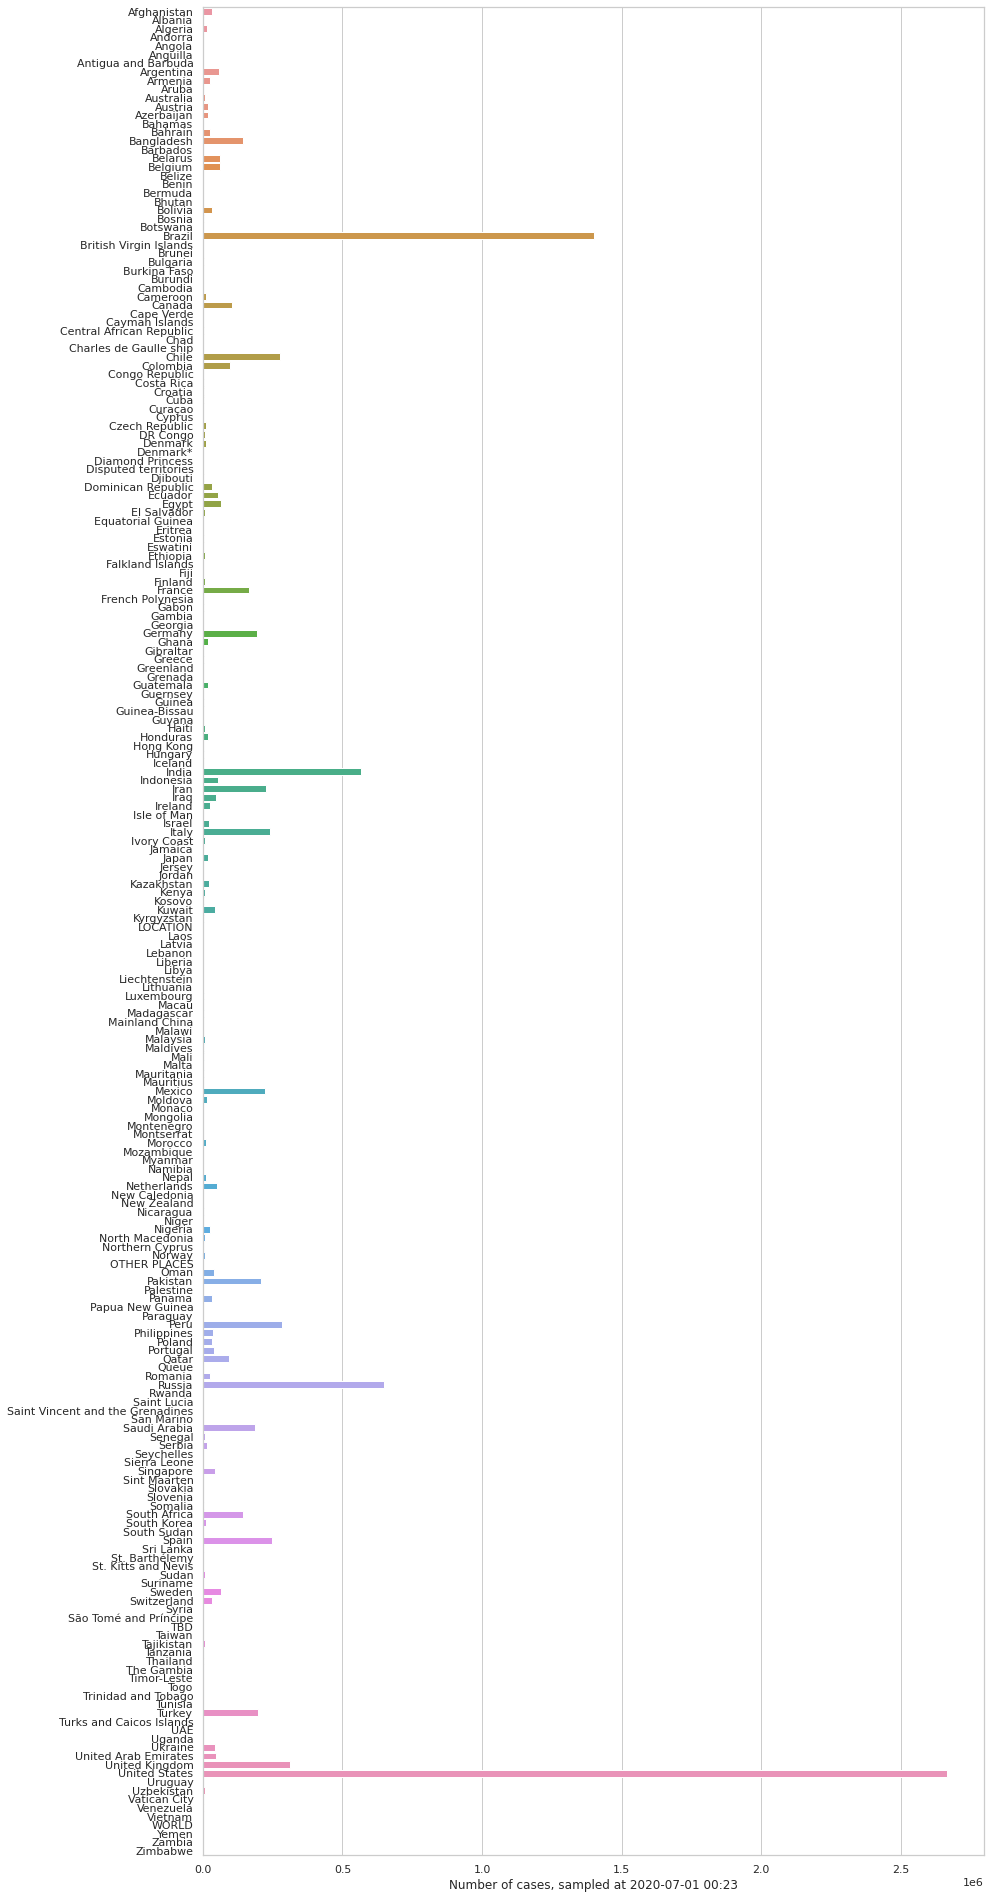

In [22]:
import seaborn as sns

series = df.iloc[-1]

sns.set(rc={'figure.figsize':(14,34)})
sns.set(style="whitegrid")

ax = sns.barplot(y=series.index, x=series)
ax.set_xlabel('Number of cases, sampled at '+series.name)


In [23]:
png_file='../images/bnonews-international.png'
fig = ax.get_figure()
fig.savefig(png_file)